In [1]:
# importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from collections import Counter
from prettytable import PrettyTable
from time import time
import datetime
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import LabelEncoder
from prettytable import PrettyTable
import sklearn
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import TimeSeriesSplit, train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.calibration import CalibratedClassifierCV

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
# reading the datasets
df_train_transaction = pd.read_csv("ieee-fraud-detection/train_transaction.csv")
df_train_identity = pd.read_csv("ieee-fraud-detection/train_identity.csv")
df_test_transaction = pd.read_csv("ieee-fraud-detection/test_transaction.csv")
df_test_identity = pd.read_csv("ieee-fraud-detection/test_identity.csv")

In [3]:
#getting the shape of each train dataset and test dataset
print("shape of train_transaction dataset:", df_train_transaction.shape)
print("shape of train_identity dataset:", df_train_identity.shape)
print("shape of test_transaction dataset:", df_test_transaction.shape)
print("shape of test_identity dataset:", df_test_identity.shape)

shape of train_transaction dataset: (590540, 394)
shape of train_identity dataset: (144233, 41)
shape of test_transaction dataset: (506691, 393)
shape of test_identity dataset: (141907, 41)


In [4]:
# merging transaction and identity data
df_train = df_train_transaction.merge(df_train_identity, on = 'TransactionID', how = 'left')
target = df_train['isFraud']     #storing class label inside a 'target' variable
# df_train.drop(['isFraud'], axis=1, inplace = True)   

df_test = df_test_transaction.merge(df_test_identity, on = 'TransactionID', how = 'left')

In [5]:
# getting the shape of the dataset
print('shape of training dataset:', df_train.shape)
print('shape of test dataset:', df_test.shape)

shape of training dataset: (590540, 434)
shape of test dataset: (506691, 433)


In [6]:
print(df_train.head(4))
print('='*80)
print(df_test.head(4))

   TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   

   card2  card3       card4  card5  ... id_31  id_32  id_33  id_34  id_35  \
0    NaN  150.0    discover  142.0  ...   NaN    NaN    NaN    NaN    NaN   
1  404.0  150.0  mastercard  102.0  ...   NaN    NaN    NaN    NaN    NaN   
2  490.0  150.0        visa  166.0  ...   NaN    NaN    NaN    NaN    NaN   
3  567.0  150.0  mastercard  117.0  ...   NaN    NaN    NaN    NaN    NaN   

  id_36 id_37  id_38  DeviceType  DeviceInfo  
0   NaN   NaN    NaN         NaN         NaN  
1   NaN   NaN    NaN         NaN         NaN  
2   NaN   NaN    NaN         NaN         NaN  
3   NaN   NaN    NaN         NaN        

In [7]:
print(df_train.columns)
print('='*80)
print(df_test.columns)

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5',
       ...
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo'],
      dtype='object', length=434)
Index(['TransactionID', 'TransactionDT', 'TransactionAmt', 'ProductCD',
       'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       ...
       'id-31', 'id-32', 'id-33', 'id-34', 'id-35', 'id-36', 'id-37', 'id-38',
       'DeviceType', 'DeviceInfo'],
      dtype='object', length=433)


We observed that The names of the id features in test dataset and train dataset did not match. While id features in the test dataset were of the form id-x, they were present in the train dataset with the name id_x, where x was a number between 01 and 38. and as a result, we will convert the test dataset's id feature names from id-x to id_x.

In [8]:
# converting the test dataset's id feature names from id-x to id_x
for i in df_test.columns:
    k = i.replace('-', '_')
    df_test.rename(columns = {i:k}, inplace = True)

In [9]:
print(df_train.columns)
print('='*50)
print(df_test.columns)

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5',
       ...
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo'],
      dtype='object', length=434)
Index(['TransactionID', 'TransactionDT', 'TransactionAmt', 'ProductCD',
       'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       ...
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo'],
      dtype='object', length=433)


#### Missing data and duplicates

In [10]:
# getting the missing data from train dataset
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data_train = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data_train.head(10)

,Total,Percent
id_24,585793,0.991962
id_25,585408,0.991310
id_07,585385,0.991271
id_08,585385,0.991271
id_21,585381,0.991264
id_26,585377,0.991257
id_27,585371,0.991247
id_23,585371,0.991247
id_22,585371,0.991247
dist2,552913,0.936284


In [11]:
# getting the missing data from test dataset
total = df_test.isnull().sum().sort_values(ascending=False)
percent = (df_test.isnull().sum()/df_test.isnull().count()).sort_values(ascending=False)
missing_data_test = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data_test.head(10)

,Total,Percent
id_24,501951,0.990645
id_25,501652,0.990055
id_26,501644,0.990039
id_21,501632,0.990016
id_08,501632,0.990016
id_07,501632,0.990016
id_27,501629,0.990010
id_23,501629,0.990010
id_22,501629,0.990010
dist2,470255,0.928090


In [12]:
## duplicates in dataset
print("number of duplicate rows in train dataset:", df_train.duplicated().sum())
print("number of duplicate rows in test dataset:", df_test.duplicated().sum())

# No duplicates found

number of duplicate rows in train dataset: 0
number of duplicate rows in test dataset: 0


In [21]:
# available categorical features
cat_fea = ['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 
           'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 
           'DeviceType', 'DeviceInfo', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17','id_18','id_19', 
           'id_20','id_21','id_22','id_23','id_24','id_25', 'id_26','id_27','id_28', 'id_29', 'id_30', 'id_31', 
           'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']

In [22]:
# available numerical features
num_fea =  ['TransactionDT', 'TransactionAmt', 'dist1', 'dist2','C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 
                 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6','D7','D8', 'D9', 'D10', 'D11', 
                 'D12', 'D13', 'D14', 'D15', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 
                 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 
                 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 
                 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 
                 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 
                 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 
                 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 
                 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V95', 'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 
                 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 
                 'V115', 'V116', 'V117', 'V118', 'V119', 'V120', 'V121', 'V122', 'V123', 'V124', 'V125', 'V126', 
                 'V127', 'V128', 'V129', 'V130', 'V131', 'V132', 'V133', 'V134', 'V135', 'V136', 'V137', 'V138', 
                 'V139', 'V140', 'V141', 'V142', 'V143', 'V144', 'V145', 'V146', 'V147', 'V148', 'V149', 'V150', 
                 'V151', 'V152', 'V153', 'V154', 'V155', 'V156', 'V157', 'V158', 'V159', 'V160', 'V161', 'V162', 
                 'V163', 'V164', 'V165', 'V166', 'V167', 'V168', 'V169', 'V170', 'V171', 'V172', 'V173', 'V174', 
                 'V175', 'V176', 'V177', 'V178', 'V179', 'V180', 'V181', 'V182', 'V183', 'V184', 'V185', 'V186', 
                 'V187', 'V188', 'V189', 'V190', 'V191', 'V192', 'V193', 'V194', 'V195', 'V196', 'V197', 'V198', 
                 'V199', 'V200', 'V201', 'V202', 'V203', 'V204', 'V205', 'V206', 'V207', 'V208', 'V209', 'V210', 
                 'V211', 'V212', 'V213', 'V214', 'V215', 'V216', 'V217', 'V218', 'V219', 'V220', 'V221', 'V222', 
                 'V223', 'V224', 'V225', 'V226', 'V227', 'V228', 'V229', 'V230', 'V231', 'V232', 'V233', 'V234', 
                 'V235', 'V236', 'V237', 'V238', 'V239', 'V240', 'V241', 'V242', 'V243', 'V244', 'V245', 'V246', 
                 'V247', 'V248', 'V249', 'V250', 'V251', 'V252', 'V253', 'V254', 'V255', 'V256', 'V257', 'V258', 
                 'V259', 'V260', 'V261', 'V262', 'V263', 'V264', 'V265', 'V266', 'V267', 'V268', 'V269', 'V270', 
                 'V271', 'V272', 'V273', 'V274', 'V275', 'V276', 'V277', 'V278', 'V279', 'V280', 'V281', 'V282', 
                 'V283', 'V284', 'V285', 'V286', 'V287', 'V288', 'V289', 'V290', 'V291', 'V292', 'V293', 'V294', 
                 'V295', 'V296', 'V297', 'V298', 'V299', 'V300', 'V301', 'V302', 'V303', 'V304', 'V305', 'V306', 
                 'V307', 'V308', 'V309', 'V310', 'V311', 'V312', 'V313', 'V314', 'V315', 'V316', 'V317', 'V318', 
                 'V319', 'V320', 'V321', 'V322', 'V323', 'V324', 'V325', 'V326', 'V327', 'V328', 'V329', 'V330', 
                 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338', 'V339', 'id_01', 'id_02', 'id_03', 
                 'id_04', 'id_05', 'id_06', 'id_07','id_08','id_09', 'id_10', 'id_11']

In [23]:
def preprocessing(data, feature):
    data[feature] = data[feature].str.replace(' ','_')
    data[feature]= data[feature].str.replace('-','_')
    data[feature] = data[feature].str.replace('/','_')
    
    return data[feature]

# preprocessing of few categorical columns

df_train['DeviceInfo'] = preprocessing(df_train, 'DeviceInfo')
df_test['DeviceInfo'] = preprocessing(df_test, 'DeviceInfo')

df_train['card4'] = preprocessing(df_train, 'card4')
df_test['card4'] = preprocessing(df_test, 'card4')

df_train['card6'] = preprocessing(df_train, 'card6')
df_test['card6'] = preprocessing(df_test, 'card6')

df_train['id_30'] = preprocessing(df_train, 'id_30')
df_test['id_30'] = preprocessing(df_test, 'id_30')

df_train['id_31'] = preprocessing(df_train, 'id_31')
df_test['id_31'] = preprocessing(df_test, 'id_31')

### Spliting the dataset into train and test

In [24]:
x_train = df_train.drop(['isFraud', 'TransactionID'], axis=1)
y_train = df_train['isFraud']

x_test = df_test.drop(['TransactionID'], axis=1)
test_ids = df_test['TransactionID'].values

del df_train, df_test

In [25]:
def label_encoding(X_train, X_test, cat_features):
    
    '''
    Utility Function to Encode Categorical Features.
    '''
    
    
    for fea in cat_features:
        X_train[fea] = X_train[fea].astype(str)
        X_test[fea] = X_test[fea].astype(str)
    
        label_enc = LabelEncoder()
        label_enc.fit(X_train[fea])
        mapping = dict(zip(label_enc.classes_, label_enc.transform(label_enc.classes_)))
        X_train[fea] = label_enc.transform(X_train[fea])
    
        # Manually Encoding the CV and Test Dataset so as to avoid error for any category which is not present in train set
    
        # All the categories which are not present in train datset are encoded as -1
    
        X_test[fea] = [-1 if mapping.get(val, -1)==-1 else mapping[val] for val in X_test[fea].values]
 

    return (X_train, X_test)

In [26]:
# normalization using minmaxscaler

def min_max_scaler(X_train, X_test):
    
    X_train_norm = X_train.copy()
    X_test_norm = X_test.copy()
    
    for fea in X_train.columns:
        if fea not in cat_fea:
            scale = MinMaxScaler()
            X_train_norm[fea] = scale.fit_transform(X_train_norm[fea].values.reshape(-1, 1))
            X_test_norm[fea] = scale.transform(X_test_norm[fea].values.reshape(-1, 1))
            X_train_norm[fea].fillna(-1,inplace=True)
            X_test_norm[fea].fillna(-1,inplace=True)

    return (X_train_norm, X_test_norm)

In [27]:
# standardizing numerical features

def standard(X_train, X_test):
    
    X_train_std = X_train.copy()
    X_test_std = X_test.copy()
    
    for fea in X_train.columns:
        if fea not in cat_fea:
            scaler = StandardScaler()
            X_train_std[fea] = scaler.fit_transform(X_train_std[fea].values.reshape(-1, 1))
            X_test_std[fea] = scaler.transform(X_test_std[fea].values.reshape(-1, 1))
            X_train_std[fea].fillna(-1,inplace=True)
            X_test_std[fea].fillna(-1,inplace=True)
    
    return (X_train_std, X_test_std)

In [28]:
def predict_and_save(prediction, name):
    
    '''
        Utility Function to save the test data predictions locally.
    '''

    df = pd.DataFrame({'TransactionID':test_ids.reshape(-1), 'isFraud':prediction.reshape(-1)})
    df = df.sort_values('TransactionID')
    df.to_csv(name, index=False)

In [29]:
# Imputing the missing values of Categorical Columns with "missing"
x_train[cat_fea] = x_train[cat_fea].fillna('missing')
x_test[cat_fea] = x_test[cat_fea].fillna('missing')


# Label Encoding Categorical Features
x_train, x_test = label_encoding(x_train, x_test, cat_fea)

In [30]:
# Set1 (Normalized numerical features)
x_train_norm, x_test_norm = min_max_scaler(x_train, x_test)

# Set2 (standardized nummerical features)
x_train_std, x_test_std = standard(x_train, x_test)

x_train[num_fea].fillna(-1, inplace = True)  # filled missing values with -1 (x_train)
x_test[num_fea].fillna(-1, inplace = True)  # filled missing values with -1 (x_test)

# Set3 (Raw)
x_train_raw = x_train
x_test_raw = x_test

#### Datasets

In [31]:
# Dataset-1
print(x_train_norm)

        TransactionDT  TransactionAmt  ProductCD  card1  card2  card3  card4  \
0        0.000000e+00        0.002137          4   3417    500     42      1   
1        6.359409e-08        0.000900          4   7922    303     42      2   
2        4.387992e-06        0.001840          4   9383    389     42      4   
3        6.295815e-06        0.001558          4   6991    466     42      2   
4        6.740974e-06        0.001558          1   9262    413     42      2   
...               ...             ...        ...    ...    ...    ...    ...   
590535   9.999947e-01        0.001526          4  10855    500     42      4   
590536   9.999948e-01        0.001229          4    390    124     42      2   
590537   9.999967e-01        0.000961          4   1782    494     42      2   
590538   9.999973e-01        0.003656          4  11847    380     42      2   
590539   1.000000e+00        0.008758          4   4361     69     42      2   

        card5  card6  addr1  ...  id_31

In [32]:
# Dataset-2
print(x_train_std)

        TransactionDT  TransactionAmt  ProductCD  card1  card2  card3  card4  \
0           -1.577987       -0.278167          4   3417    500     42      1   
1           -1.577986       -0.443327          4   7922    303     42      2   
2           -1.577972       -0.317889          4   9383    389     42      4   
3           -1.577965       -0.355521          4   6991    466     42      2   
4           -1.577964       -0.355521          1   9262    413     42      2   
...               ...             ...        ...    ...    ...    ...    ...   
590535       1.827666       -0.359702          4  10855    500     42      4   
590536       1.827666       -0.399424          4    390    124     42      2   
590537       1.827673       -0.435174          4   1782    494     42      2   
590538       1.827675       -0.075376          4  11847    380     42      2   
590539       1.827684        0.605960          4   4361     69     42      2   

        card5  card6  addr1  ...  id_31

In [33]:
# Dataset-3
print(x_train_raw)

        TransactionDT  TransactionAmt  ProductCD  card1  card2  card3  card4  \
0               86400           68.50          4   3417    500     42      1   
1               86401           29.00          4   7922    303     42      2   
2               86469           59.00          4   9383    389     42      4   
3               86499           50.00          4   6991    466     42      2   
4               86506           50.00          1   9262    413     42      2   
...               ...             ...        ...    ...    ...    ...    ...   
590535       15811047           49.00          4  10855    500     42      4   
590536       15811049           39.50          4    390    124     42      2   
590537       15811079           30.95          4   1782    494     42      2   
590538       15811088          117.00          4  11847    380     42      2   
590539       15811131          279.95          4   4361     69     42      2   

        card5  card6  addr1  ...  id_31

In [34]:
print("*"*60)
print("\n Train Dataset Set1 Shape : {} \n".format(x_train_norm.shape))
print("\n Test Dataset Set1 Shape : {} \n".format(x_test_norm.shape))
print("*"*60)
print("\n Train Dataset Set2 Shape : {} \n".format(x_train_std.shape))
print("\n Test Dataset Set2 Shape : {} \n".format(x_test_std.shape))
print("*"*60)
print("\n Train Dataset Set3 Shape : {} \n".format(x_train_raw.shape))
print("\n Test Dataset Set3 Shape : {} \n".format(x_test_raw.shape))
print("*"*60)

************************************************************

 Train Dataset Set1 Shape : (590540, 431) 


 Test Dataset Set1 Shape : (506691, 431) 

************************************************************

 Train Dataset Set2 Shape : (590540, 431) 


 Test Dataset Set2 Shape : (506691, 431) 

************************************************************

 Train Dataset Set3 Shape : (590540, 431) 


 Test Dataset Set3 Shape : (506691, 431) 

************************************************************


### Baseline Models

#### Logistic Regression- Set 1

In [35]:
log_reg = LogisticRegression(class_weight = 'balanced', random_state = 10, n_jobs = -1) 
log_reg.fit(x_train_norm, y_train)

LogisticRegression(class_weight='balanced', n_jobs=-1, random_state=10)

In [36]:
log_reg_test_proba = log_reg.predict_proba(x_test_norm)[:,1]
predict_and_save(log_reg_test_proba, 'log_reg_pred_bsl_set1.csv')

#### Gaussian NB - Set 1

In [37]:
naive = GaussianNB()
naive.fit(x_train_norm, y_train)

GaussianNB()

In [38]:
nb_test_proba = naive.predict_proba(x_test_norm)[:,1]
predict_and_save(nb_test_proba, 'nb_pred_bsl_set1.csv')

#### Decision Tree - Set 1

In [39]:
tree =  DecisionTreeClassifier(class_weight='balanced', random_state=10)
tree.fit(x_train_norm, y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=10)

In [40]:
tree_test_proba = tree.predict_proba(x_test_norm)[:,1]
predict_and_save(tree_test_proba, 'dt_pred_bsl_set1.csv')

#### Random Forest - Set 1

In [41]:
forest =  RandomForestClassifier(class_weight = 'balanced', random_state = 10, n_jobs = -1)
forest.fit(x_train_norm, y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=10)

In [42]:
forest_test_proba = forest.predict_proba(x_test_norm)[:,1]
predict_and_save(forest_test_proba, 'rf_pred_bsl_set1.csv')

#### Adaptive Boosting Classifier- Set 1

In [43]:
adaboost =  AdaBoostClassifier(random_state = 10)
adaboost.fit(x_train_norm, y_train)

AdaBoostClassifier(random_state=10)

In [44]:
adaboost_test_proba = adaboost.predict_proba(x_test_norm)[:,1]
predict_and_save(adaboost_test_proba, 'adaboost_pred_bsl_set1.csv')

#### XGBoost - Set 1

In [45]:
xgboost =  XGBClassifier(objective='binary:logistic', eval_metric = 'auc', random_state = 10)
xgboost.fit(x_train_norm, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=10, ...)

In [46]:
xgboost_test_proba = xgboost.predict_proba(x_test_norm)[:,1]
predict_and_save(xgboost_test_proba, 'xgboost_pred_bsl_set1.csv')

#### Set 1 results 

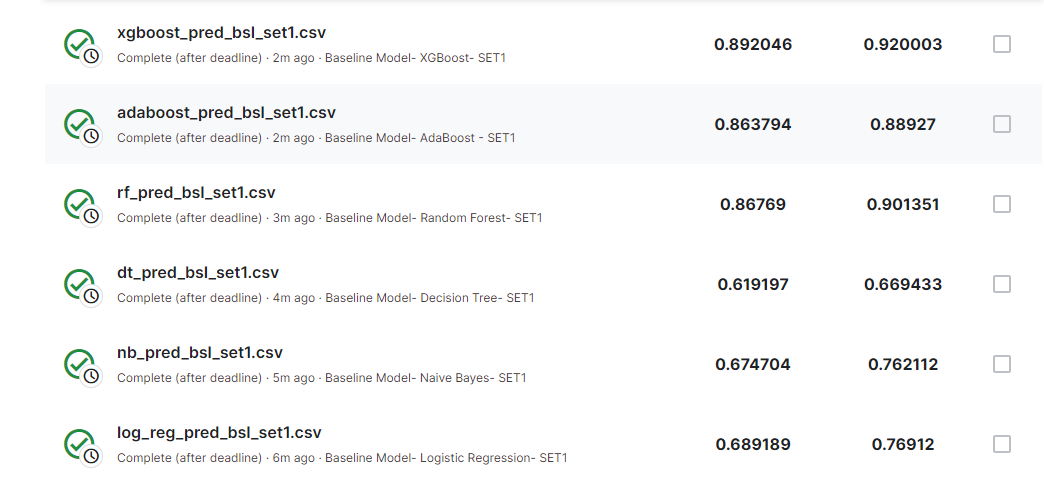

**Observation:** It is abundantly evident from the results above that the XGBoost solves our situation the best. Therefore, going forward, we will be using XGBoost for training.

#### XGBoost - Set 2

In [47]:
xgboost =  XGBClassifier(objective='binary:logistic', eval_metric = 'auc', random_state = 10)
xgboost.fit(x_train_std, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=10, ...)

In [48]:
xgboost_test_proba = xgboost.predict_proba(x_test_std)[:,1]
predict_and_save(xgboost_test_proba, 'xgboost_pred_bsl_set2.csv')

#### XGBoost - Set 3

In [49]:
xgboost =  XGBClassifier(objective='binary:logistic', eval_metric = 'auc', random_state = 10)
xgboost.fit(x_train_raw, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=10, ...)

In [50]:
xgboost_test_proba = xgboost.predict_proba(x_test_raw)[:,1]
predict_and_save(xgboost_test_proba, 'xgboost_pred_bsl_set3.csv')

#### XGBoost results for all the sets

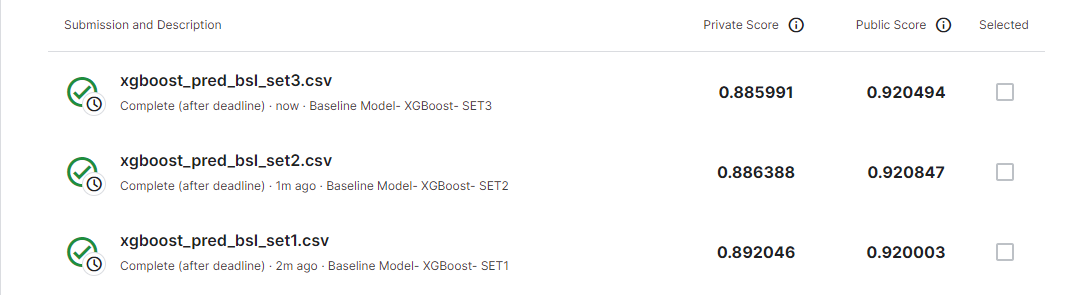

**Observation:** XGBoost works best with standardized data